In [1]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd

from time import sleep

In [2]:
!pip install sounddevice

In [5]:
from sklearn.model_selection import train_test_split

# load data
data_dir = '/Users/mac/Downloads'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']

# split train dataset into local train and test
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, shuffle=True)
fs = 16000

print(x_test.shape, y_test.shape, x_global_test.shape)

(563, 16000) (563,) (750, 16000)


In [6]:
# play a few samples
for k in np.random.choice(np.arange(len(x_train)), 3):
    print(int(y_train[k]))
    sd.play(x_train[k], fs)
    sleep(1.2)

1
3
3


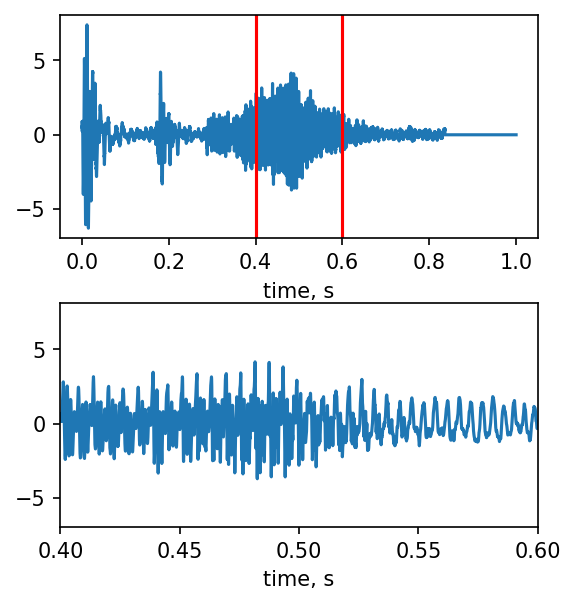

In [7]:
# plot some sample
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()

x = x_train[y_train==1][0]

time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')
sd.play(x, fs)

(129,) (1687, 129)


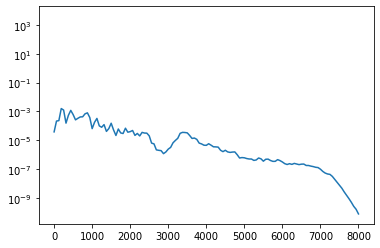

In [8]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, fs, axis=1, )
print(freq.shape, x_spec_train.shape)
plt.plot(freq, x_spec_train[y_train==1][1])
plt.semilogy(0, 4000)

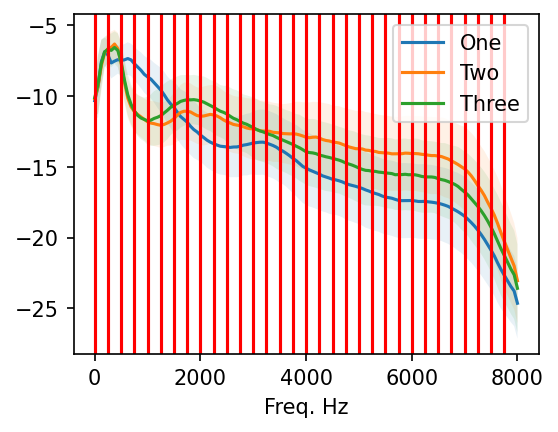

In [62]:
# average spectums for each class
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.1)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = []
for i in range(0, 8000, 250):
    band.append(i)
[plt.axvline(b, color='r') for b in band]

In [63]:
# define features transformer
def extract_features(x, band):
    freq, spec = sg.welch(x, fs, axis=1)
    #features = spec[:, (freq>band[0]) & (freq<band[1])].mean(1).reshape(-1, 1)
    features = pd.DataFrame()
    for i in range(len(band) - 1):
        feature_i = spec[:, (freq > band[i]) & (freq < band[i + 1])].mean(1)
        name_col = 'feature_' + str(i)
        features[name_col] = feature_i
    return features


In [64]:
# extract features
f_train = extract_features(x_train, band)
f_test  = extract_features(x_test, band)
f_global_test = extract_features(x_global_test, band)

In [65]:
# fit model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

classifier = ExtraTreesClassifier()
classifier.fit(f_train, y_train)

ExtraTreesClassifier()

In [66]:
# collect predictions
y_train_pred = classifier.predict(f_train).astype(int)
y_test_pred = classifier.predict(f_test).astype(int)
y_global_test_pred = classifier.predict(f_global_test).astype(int)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.8880994671403197)

In [47]:
# play a few predictions
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for k in np.random.choice(np.arange(len(x_test)), 2):
    sd.play(x_test[k], fs)
    print('{:12s} {:12s} {}'.format(str(int(y_test_pred[k])), str(int(y_test[k])), y_test_pred[k]==y_test[k]))
    sleep(1.2)

prediction   actual       error       
3            3            True
3            3            True


In [67]:
# save test data predictions

df = pd.DataFrame(data=y_global_test_pred, columns=['Category'])
df.to_csv('lect8_one_band_benchmark.csv', index_label='Id')
df

,Category
0,2
1,1
2,2
3,2
4,1
...,...
745,2
746,1
747,2
748,2


In [68]:
df = pd.DataFrame(data=y_global_test_pred*0 + 1, columns=['Category'])
df.to_csv('lect8_all_ones_benchmark.csv', index_label='Id')
df

,Category
0,1
1,1
2,1
3,1
4,1
...,...
745,1
746,1
747,1
748,1
